<img src="./pics/c9e59b2f85ae246ccdca754c1e71ce69.jpg"  width="100" height= "100" align = "right"/>
# <font color=darkblue>DSCI 521 Project</font>
## <font color=darkred>*Musical Features Prediction Using Machine Learning Algorithms* </font>
#### <font color= darkgreen>*Using Audio Data Extracted From Free Music Archive Website* <br /> </font>
[Kiana Montazeri](https://github.com/kianamon)<sup>1</sup>, [Farnaz Ghashami](https://github.com/FarnazGhashami)<sup>1</sup>,
[Shideh Shams Amiri](https://github.com/shidehsh)<sup>1</sup>.<br>
<sup>1</sup>[Drexel University, Philadelphia, PA](https://drexel.edu/cci/academics/information-science-department/)

<img src="./pics/2.jpg"  width="900" height= "300" align = "center"/>

In [1]:
#Libraries in Use
from pprint import pprint
from collections import defaultdict
import re
import csv
import pandas as pd
import IPython.display as ipd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from functools import reduce
import seaborn as sns

##### Loading the data:

In [2]:
df_trackinfo = pd.read_csv("./Data/prepdata/trackinfo.csv", low_memory=False)
df_albums = pd.read_csv("./Data/prepdata/Albums.csv", low_memory=False)
df_artist = pd.read_csv("./Data/prepdata/Artist.csv", low_memory=False)
df_genres = pd.read_csv("./Data/prepdata/Genres.csv", low_memory=False)
df_Audio_Features = pd.read_csv("./Data/prepdata/Audio_Features.csv", low_memory=False)
df_Social_Features = pd.read_csv("./Data/prepdata/Social_Features.csv", low_memory=False)
temporal_features = pd.read_csv("./Data/prepdata/Temporal_Features.csv", low_memory=False)

#### A little bit of pre-processing:

In [18]:
dfs = [df_trackinfo,df_albums,df_artist]

In [19]:
df_info = reduce(lambda left,right: pd.merge(left,right,on='trackID'), dfs)

In [20]:
df_info.drop(['Unnamed: 0_x', "Unnamed: 0_y", 'Unnamed: 0', 'date_created_y'], axis=1, inplace=True)

In [21]:
df_info.shape #we have track info for 106574 songs

(106574, 30)

In [22]:
df_info['date_created_x'] = pd.to_datetime(df_info['date_created_x'])

In [23]:
df_info['date_released'] = pd.to_datetime(df_info['date_released'])

In [24]:
subset_info1 = df_info[
    (df_info["genre_top"]=="Pop") | (df_info["genre_top"]=="Rock") | 
    (df_info["genre_top"]=="Classical") | (df_info["genre_top"]=="Instrumental")]

In [25]:
subset_info2 = df_info[
    (df_info["genre_top"]=="Country") | (df_info["genre_top"]=="Jazz") | 
    (df_info["genre_top"]=="Folk") | (df_info["genre_top"]=="Blues")]

In [26]:
sns.set(rc={'figure.figsize':(15,10)})

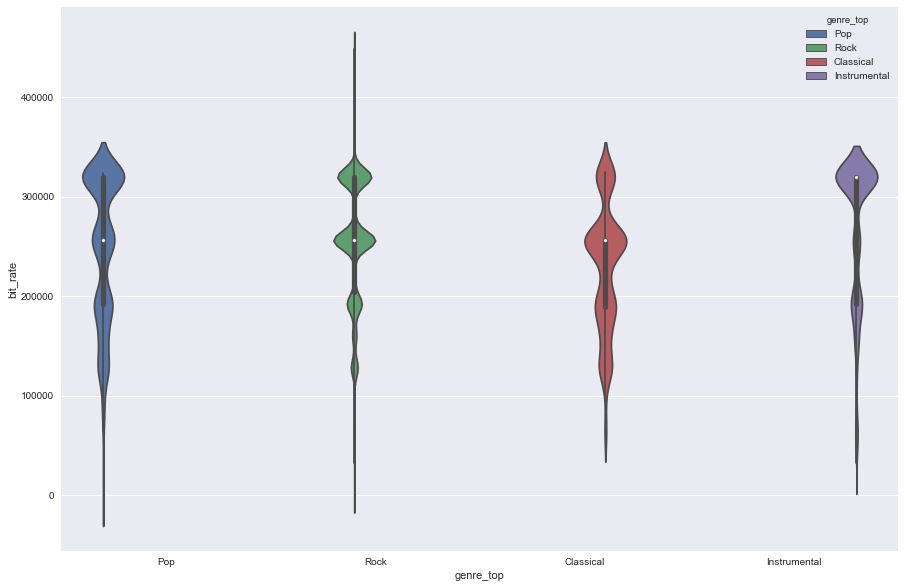

In [27]:
# plotting the violinplot
sns.violinplot(x="genre_top",y="bit_rate", hue="genre_top", data=subset_info1);
plt.show()

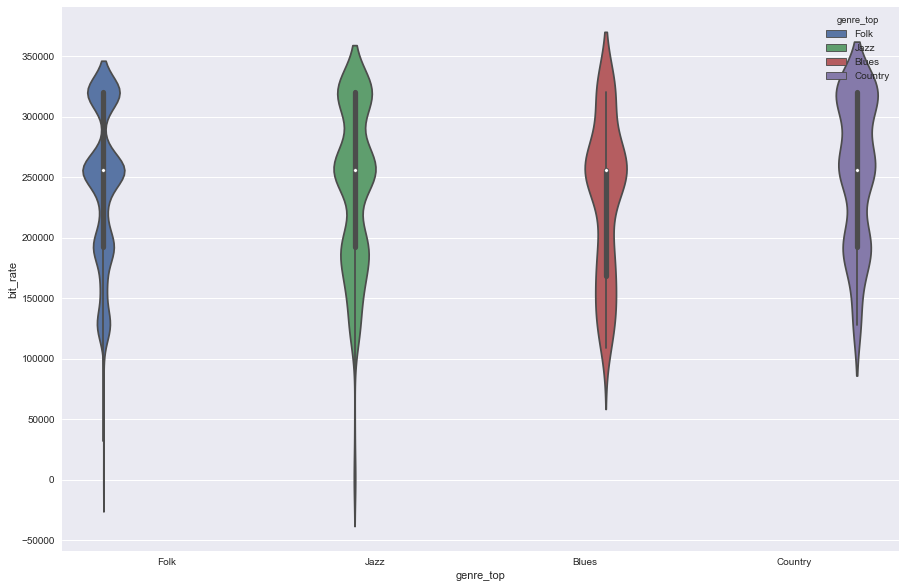

In [28]:
# plotting the violinplot
sns.violinplot(x="genre_top",y="bit_rate", hue="genre_top", data=subset_info2);
plt.show()

<font color=darkblue>Violin plot displays the distribution of data across labels.</font>

In [29]:
df_info.drop(['genres', 'genres_all', 'type', 'title_x', 'title_y'], axis=1, inplace=True)

In [30]:
df_info.head()

,trackID,bit_rate,comments_x,date_created_x,duration,favorites_x,genre_top,interest,license,listens_x,...,id_x,information,listens_y,tags_y,tracks,favorites,id_y,members,name,tags
0,2,256000,0,2008-11-26 01:48:12,168,2,Hip-Hop,4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,...,1,<p></p>,6073,[],7,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
1,3,256000,0,2008-11-26 01:48:14,237,1,Hip-Hop,1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,...,1,<p></p>,6073,[],7,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
2,5,256000,0,2008-11-26 01:48:20,206,6,Hip-Hop,1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,...,1,<p></p>,6073,[],7,9,1,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,['awol']
3,10,192000,0,2008-11-25 17:49:06,161,178,Pop,54881,Attribution-NonCommercial-NoDerivatives (aka M...,50135,...,6,No Additional Information Available,47632,[],2,74,6,"Kurt Vile, the Violators",Kurt Vile,"['philly', 'kurt vile']"
4,20,256000,0,2008-11-26 01:48:56,311,0,Hip-Hop,978,Attribution-NonCommercial-NoDerivatives (aka M...,361,...,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,[],13,10,4,Nicky Cook\n,Nicky Cook,"['instrumentals', 'experimental pop', 'post pu..."


In [32]:
df_info.to_csv("./Data/prepdata/info.csv", sep=',') #write the df for future use

In [33]:
parse_dates = ['date_created_x', 'date_released']
df_info = pd.read_csv("./Data/prepdata/info.csv", parse_dates = parse_dates)

<font color=darkblue>We start from generating train and test sets for trackinfo dataset. Multiclass variables should be encoded to numerics using `LabelEncoder()`</font>

In [34]:
# create the Labelencoder object
le = LabelEncoder()

#convert the categorical columns into numeric
df_info['genre_top'] = le.fit_transform(df_info['genre_top'])
df_info['tags_x'] = le.fit_transform(df_info['tags_x'])
df_info['members'] = le.fit_transform(df_info['members'])
df_info['name'] = le.fit_transform(df_info['name'])
df_info['tags'] = le.fit_transform(df_info['tags'])
df_info['tags_y'] = le.fit_transform(df_info['tags_y'])
df_info['license'] = le.fit_transform(df_info['license'])
df_info['information'] = le.fit_transform(df_info['information'])
df_info['date_created_x'] = le.fit_transform(df_info['date_created_x'])
df_info['date_released'] = le.fit_transform(df_info['date_released'])
df_info.dtypes

Unnamed: 0        int64
trackID           int64
bit_rate          int64
comments_x        int64
date_created_x    int64
duration          int64
favorites_x       int64
genre_top         int64
interest          int64
license           int64
listens_x         int64
number            int64
tags_x            int64
comments_y        int64
date_released     int64
favorites_y       int64
id_x              int64
information       int64
listens_y         int64
tags_y            int64
tracks            int64
favorites         int64
id_y              int64
members           int64
name              int64
tags              int64
dtype: object

In [35]:
df_info.head()

,Unnamed: 0,trackID,bit_rate,comments_x,date_created_x,duration,favorites_x,genre_top,interest,license,...,id_x,information,listens_y,tags_y,tracks,favorites,id_y,members,name,tags
0,0,2,256000,0,82,168,2,7,4656,36,...,1,1644,6073,2387,7,9,1,11914,299,1236
1,1,3,256000,0,83,237,1,7,1470,36,...,1,1644,6073,2387,7,9,1,11914,299,1236
2,2,5,256000,0,84,206,6,7,1933,36,...,1,1644,6073,2387,7,9,1,11914,299,1236
3,3,10,192000,0,0,161,178,12,54881,24,...,6,11053,47632,2387,2,74,6,7780,7425,10645
4,4,20,256000,0,86,311,0,7,978,24,...,4,10724,2710,2387,13,10,4,9984,9558,6377


#### Prepare the train, test, validation sets:

In [36]:
#select columns other than 'genre_top'
cols = [col for col in df_info.columns if col not in ['genre_top']]

#dropping the 'genre_top' column
data = df_info[cols]

#assigning the genre column as target
target = df_info['genre_top']

data.head(n=2)

,Unnamed: 0,trackID,bit_rate,comments_x,date_created_x,duration,favorites_x,interest,license,listens_x,...,id_x,information,listens_y,tags_y,tracks,favorites,id_y,members,name,tags
0,0,2,256000,0,82,168,2,4656,36,1293,...,1,1644,6073,2387,7,9,1,11914,299,1236
1,1,3,256000,0,83,237,1,1470,36,514,...,1,1644,6073,2387,7,9,1,11914,299,1236


In [37]:
#split data set into train and test sets
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.30, random_state = 10)

<font color=darkblue>We want to build our model based on logistic regression.</font>

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=1000)

In [40]:
logisticRegr.fit(data_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
predictions = logisticRegr.predict(data_test)

In [42]:
# Use score method to get accuracy of model
score = logisticRegr.score(data_test, target_test)
print(score)

0.5788321396178026


**<font color=green>The accuracy of our model is not very high but still is much better than random guessing.(100/16 %)</font>**